# Распознавание номера с помощью модели

In [1]:
import os
import pickle

Загрузим модель из файла. Если файла не существует - обучим ее?

In [2]:
UMODEL='telno1.mdl'

if os.path.isfile(UMODEL):
    MODEL=pickle.load(open(UMODEL, 'rb'))
    print('...using model from {}'.format(UMODEL))
else:
    MODEL=None
    print('model was not found!')
        

use model from telno1.mdl


In [3]:
MODEL

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  shrinking=True, tol=0.001, verbose=False)

Обученная нами модель умеет распозновать отдельные цифры размером 16х8 пикселей. Поэтому для распозования нового номера телефона мы должны повтороить процедура разрезания его на подходящие фрагменты. Для этого нам также потребуется функция rezak. 

In [29]:
def rezak(I, width=8):
    '''split to binary matrix 16x8
        '''
    #~ shape==(20, 124, 3)
    if len(I.shape)>2:
        I=1-I[4:,:,0]
    
    if I.shape[0]>13:
        I=I[-15:-2,:]
        
    end=I.shape[1]-1
    
        
    #chop by vertical gap
    bb=I[:6,:].sum(0)!=0
    d= diff(array(bb, dtype=int))
    iiab=find(d>0)
    iiad=find(d<0)
    #check?
    assert(len(iiab)==len(iiad))
    centra=1+iiab+(-iiab+iiad)/2 * ones([2,1], int)
    lim=array([[-(width/2)],[-(width/2)+width]]).repeat(iiab.shape[0],1)
    lim+=centra
    if lim[0,0]<0:
        n=-lim[0,0]
        I=hstack([zeros((I.shape[0],n), int), I])
        lim+=n
    if lim[-1,-1]>end:
        n=lim[-1,-1]-end
        I=hstack([I, zeros((I.shape[0],n), int)])
        
    for i in range(lim.shape[1]):
        iab,iad=lim[:,i]
        
        C=I[:,iab:iad]
        yield C
    


Откроем и разрежем на цифры картинку с каким-нибудь номером

In [25]:
u=r'telno\2695156.png'
CC=rezak(imread(u))
CC=list(CC)
len(CC)


7

Разрезание городского номера дало 7 образцов цифр. Посмотрим, сможет ли распознать их модель?

In [10]:
sTel='' # заготовим пустую строку для угаданного номера

for C in CC: # пройдемся в цикле по всем образцам
    #подготовим данные также, как мы делали при создании обучающей выборки
    data=C.reshape((1, -1))
    # let's predict (англ. предсказание) - ТРАХ-те-бе-дох!
    s=MODEL.predict(data)
    
    s=int(s) # привидем в числовой вид
    sTel+=str(s)  #добавим в конец строки

sTel

'2695156'

Первая из цифр-картинок выглядела так:

(-0.5, 7.5, 12.5, -0.5)

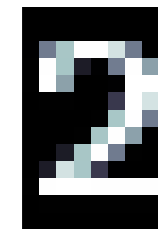

C:\a\WinPython\python-3.3.0.amd64\lib\site-packages\IPython\utils\jsonutil.py:121: DeprecationWarning: encodestring() is a deprecated alias, use encodebytes()
  encoded['image/png'] = encodestring(pngdata).decode('ascii')


In [26]:
imshow(CC[0], cmap='bone', interpolation='none'); axis('off')

Последняя - так:

(-0.5, 7.5, 12.5, -0.5)

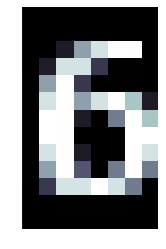

C:\a\WinPython\python-3.3.0.amd64\lib\site-packages\IPython\utils\jsonutil.py:121: DeprecationWarning: encodestring() is a deprecated alias, use encodebytes()
  encoded['image/png'] = encodestring(pngdata).decode('ascii')


In [15]:
imshow(CC[-1], cmap='bone', interpolation='none'); axis('off')

Вам легко определить цифры на картинках, потому что вы учили их в детстве. Но теперь компьютер сам научился различать эти цифры! Такой подход к решению задач, в котором машины сами обучаются давать правильные ответы, называется "машинным обучением" - [machine learning](http://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5).

### Апробация модели на картинках с другим шрифтом

Загрузим картинку с номером телефона с другого сайта - цифры в данном случае написаны тонким шрифтом.

In [30]:
u=r'telno\avito89034706554.png'
CC=rezak(imread(u))
CC=list(CC)
len(CC)


11

Цифра 6 из этого номера выглядит так:  (если приглядеться, то она не только стройнее, но и "выше" на один пиксель, чем жирненькая на предыдущей картинке)

(-0.5, 7.5, 12.5, -0.5)

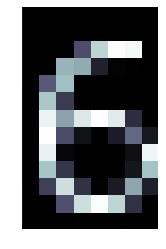

C:\a\WinPython\python-3.3.0.amd64\lib\site-packages\IPython\utils\jsonutil.py:121: DeprecationWarning: encodestring() is a deprecated alias, use encodebytes()
  encoded['image/png'] = encodestring(pngdata).decode('ascii')


In [34]:
imshow(CC[-4], cmap='bone', interpolation='none'); axis('off')

Распознаем номер...

In [32]:
sTel=''
for C in CC:
    s=MODEL.predict(C.reshape((1, -1)))
    sTel+=str(int(s))

sTel

'39034706334'

In [33]:
u

'telno\\avito89034706554.png'

Видно, что часть цифр модель распознала неправильно, в частности 8 как 3, 5 как 3. Однако остальные цифры несмотря на разницу в написании распознаны правильно!

### О полноте обучающей выборки

Чтобы модель работала без ошибок, нужно обучить ее на выборке, включающей по возможности все варианты образцов, которые ей предстоит распознавать.

Параметры модели можно подстроить таким образом, чтобы она была более терпима к отклонениям в написании. Однако, при этом потенциально может возникнуть больше ошибок.

Если у вас бывает только два написания цифр и вы заранее знаете, где какой, то надежнее и эффективнее обучить две модели на соответствующих выборках для распознавания одного и другого написания. С другой стороны, смешав обучающие выборки, можно обучить модель на распознавание цифр вообще, независимо от написания. При этом надо уделить внимание центрированию изображений, приведению их к одинаковому размеру и прочим мерам стандартизации.